In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
import torch

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dt_unclean = pd.read_excel("for_textclassification_data.xlsx")

In [3]:
df = dt_unclean.dropna(subset=["Comment"])

In [7]:
df.Comment

5        When we view the statement especially the tran...
14       Enable eStatements for Banking Investment prod...
23       The DBS Digibank app to obtain the digital tok...
27       When I tried to return to DBS Internet Banking...
29       Internet banking and DBS Vickers websites are ...
                               ...                        
14101                                                   Ok
14102                    exchange rate not available-2days
14104                                            Great app
14115                                                   No
14126    Why am I not able to place deposits longer tha...
Name: Comment, Length: 1785, dtype: object

In [5]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Tokenize and generate BERT embeddings for your reviews
def generate_bert_embeddings(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  # Average pooling

In [8]:
# Apply BERT embeddings to your entire dataset
embeddings = df.Comment.apply(generate_bert_embeddings)

In [18]:
# Combine the embeddings into a feature matrix
X = torch.cat(embeddings.tolist()).numpy()

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df["channels"], test_size=0.2, random_state=42)


In [22]:
# Train an SVM model
svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [23]:
# Evaluate the SVM model
y_pred = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

                       precision    recall  f1-score   support

                    0       0.80      0.89      0.84       125
                 cctr       0.20      0.09      0.13        11
      cctr or chatbot       0.00      0.00      0.00         5
             channels       0.00      0.00      0.00         1
chatbot or live agent       0.58      0.70      0.64        30
             ib or mb       0.53      0.58      0.55        57
     internet banking       0.25      0.20      0.22         5
       mobile banking       0.74      0.64      0.69        36
                 pweb       0.57      0.52      0.55        82
   rewards redemption       0.00      0.00      0.00         2
                 sweb       1.00      0.50      0.67         2
              vickers       0.00      0.00      0.00         1

             accuracy                           0.66       357
            macro avg       0.39      0.34      0.36       357
         weighted avg       0.64      0.66      0.64 

C:\Users\Xavior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xavior\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

In [40]:
class_labels = df["channels"].unique()

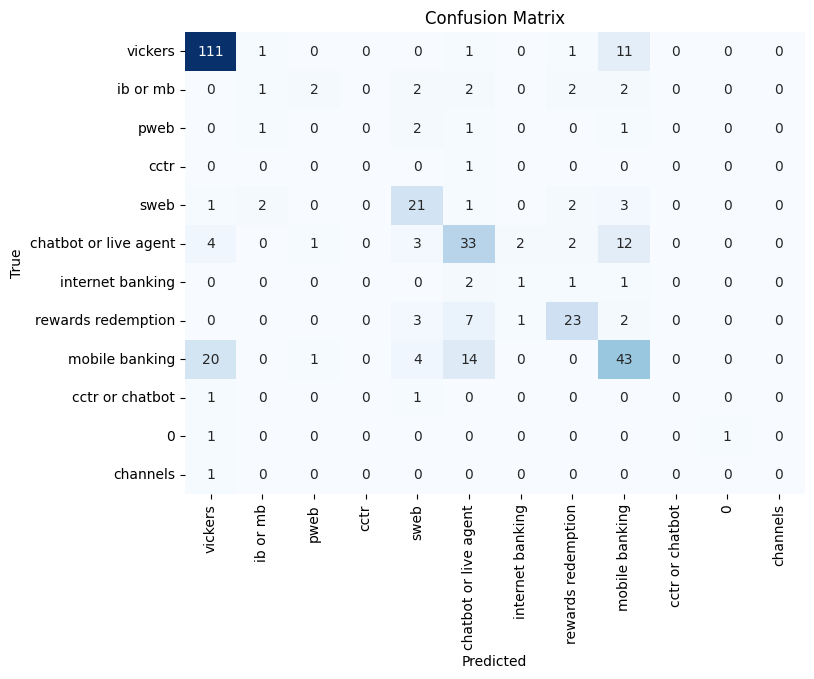

In [42]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [26]:
review = "everytime login the system kick me out"

In [27]:
e1 = generate_bert_embeddings(review)

In [29]:
y1 = svm_classifier.predict(e1)

In [30]:
y1

array(['ib or mb'], dtype=object)

In [31]:
review2 = "not bad"
e2 = generate_bert_embeddings(review2)

In [32]:
y2 = svm_classifier.predict(e2)

In [33]:
y2

array(['0'], dtype=object)

In [34]:
review3 = "Worst customer service I've seen so far. The verification process on other similar sites takes about 5 minutes. Here, you cannot complete it in hours. They do not accept your photos for hours and when you try to contact customer support, you get instantly spammed by their bot. Look for alternatives."

In [35]:
e3 = generate_bert_embeddings(review3)


In [36]:
y3 = svm_classifier.predict(e3)

In [37]:
y3

array(['chatbot or live agent'], dtype=object)

In [43]:
import joblib

In [44]:
# Save the trained model to a file
model_filename = "channels_svm_model.pkl"
joblib.dump(svm_classifier, model_filename)

# # Later, when you want to load the model for prediction
# loaded_model = joblib.load(model_filename)

['channels_svm_model.pkl']

In [46]:
import numpy as np

# Convert the embeddings to a NumPy array
embedding_arrays = np.array(embeddings.tolist())

# Save the embeddings as a NumPy binary file (e.g., .npy)
np.save("bert_embeddings.npy", embedding_arrays)

# # Load the saved BERT embeddings
# loaded_embeddings = np.load("bert_embeddings.npy")

C:\Users\Xavior\AppData\Local\Temp\ipykernel_48868\3322579334.py:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  embedding_arrays = np.array(embeddings.tolist())
C:\Users\Xavior\AppData\Local\Temp\ipykernel_48868\3322579334.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  embedding_arrays = np.array(embeddings.tolist())
